##### THIS NOTEBOOK IS FOR EXPLORATION AND DOES NOT REPRESENT THE FINAL NOTEBOOK

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn                   import linear_model, ensemble, preprocessing
from sklearn.model_selection   import train_test_split
from sklearn.feature_selection import RFE
from sklearn.metrics           import r2_score, mean_squared_error, accuracy_score
from sklearn.neighbors         import KNeighborsClassifier
from sklearn.naive_bayes       import MultinomialNB, GaussianNB

plt.style.use('ggplot')
%matplotlib inline
plt.rcParams['figure.figsize'] = [15, 12]


In [2]:
covid_df = pd.read_csv('data/covid_nsw_data.csv', parse_dates=['notification_date'])
income_df = pd.read_csv('data/income_data.csv', index_col=['Postcode'])
opal_df = pd.read_csv('data/opal_patronage_data.csv', parse_dates=['trip_origin_date'])

In [3]:
# Changing header names for dataframes
covid_headers = ['date', 'postcode', 'source', 'health_district', 'health_district_name', 'local_gov_code', 'local_gov_name']
opal_headers = ['date', 'mode_type', 'region', 'tap_hour', 'tap_on', 'tap_off']

covid_df.columns = covid_headers
opal_df.columns = opal_headers

In [4]:
#take columns that are needed and update dataframes
covid_df = covid_df[['date', 'postcode', 'source', 'health_district_name', 'local_gov_name']]
opal_df = opal_df[['date', 'mode_type', 'region', 'tap_on', 'tap_off']]

In [5]:
covid_df.head()

,date,postcode,source,health_district_name,local_gov_name
0,2020-01-25,2134.0,Overseas,Sydney,Burwood (A)
1,2020-01-25,2121.0,Overseas,Northern Sydney,Parramatta (C)
2,2020-01-25,2071.0,Overseas,Northern Sydney,Ku-ring-gai (A)
3,2020-01-27,2033.0,Overseas,South Eastern Sydney,Randwick (C)
4,2020-03-01,2163.0,Overseas,South Western Sydney,Fairfield (C)


In [6]:
opal_df.head()

,date,mode_type,region,tap_on,tap_off
0,2020-01-01,Bus,Chatswood,<50,<50
1,2020-01-01,Bus,Macquarie Park,<50,<50
2,2020-01-01,Bus,Newcastle and surrounds,<50,<50
3,2020-01-01,Bus,North Sydney,700,100
4,2020-01-01,Bus,Other,4500,3200


In [7]:
#groupby day
covid_df['health_district_name'].unique()

array(['Sydney', 'Northern Sydney', 'South Eastern Sydney',
       'South Western Sydney', 'Western Sydney', 'Southern NSW', nan,
       'Nepean Blue Mountains', 'Western NSW', 'Central Coast',
       'Mid North Coast', 'Hunter New England', 'Northern NSW',
       'Illawarra Shoalhaven', 'Network with Vic', 'Murrumbidgee',
       'Far West'], dtype=object)

Split the covid data into total cases and locally acquired cases

In [8]:
total_cases = covid_df.groupby('date').size()
local_covid_df = covid_df[covid_df['source'] != 'Overseas']
local_cases = local_covid_df.groupby('date').size()

In [9]:
local_cases = local_cases.reindex(pd.date_range(local_cases.index[0], local_cases.index[-1]), fill_value=0)
total_cases = total_cases.reindex(pd.date_range(total_cases.index[0], total_cases.index[-1]), fill_value=0)

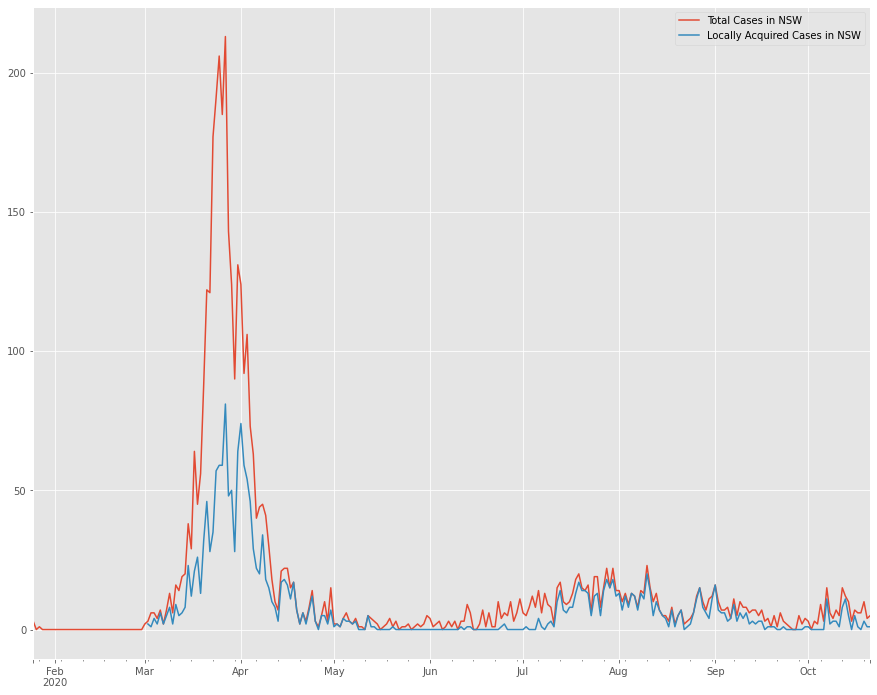

In [10]:
fig, ax = plt.subplots()
total_cases.plot(ax=ax)
local_cases.plot(ax=ax)
ax.legend(['Total Cases in NSW', 'Locally Acquired Cases in NSW'])

Get the train data. Change the "<50" values into 0.

In [11]:
train_data = opal_df[opal_df['mode_type'] == 'Train']

tap_on_num = pd.to_numeric(train_data['tap_on'], errors='coerce').fillna(0).astype(np.int32)
tap_off_num = pd.to_numeric(train_data['tap_off'], errors='coerce').fillna(0).astype(np.int32)

train_data = train_data.assign(tap_on=tap_on_num, tap_off=tap_off_num)

In [12]:
train_data.head()

,date,mode_type,region,tap_on,tap_off
226,2020-01-01,Train,Chatswood,200,1000
227,2020-01-01,Train,Macquarie Park,100,400
228,2020-01-01,Train,Newcastle and surrounds,100,0
229,2020-01-01,Train,North Sydney,11200,400
230,2020-01-01,Train,Other,9100,14800


Group the data so there are total tap on and total tap off in the region for each day

In [13]:
train_grouped = train_data.groupby(['date', 'region']).sum()
train_grouped[:10]

tap_on  tap_off
date       region                                   
2020-01-01 All - NSW                 647700   647400
           Chatswood                  11000    13900
           Macquarie Park              4600     6800
           Newcastle and surrounds      900      400
           North Sydney               37700    12300
           Other                     312300   416600
           Parramatta                 13000    19800
           Strathfield                12500    17200
           Sydney CBD                253200   158300
           Wollongong and surrounds    2500     2100

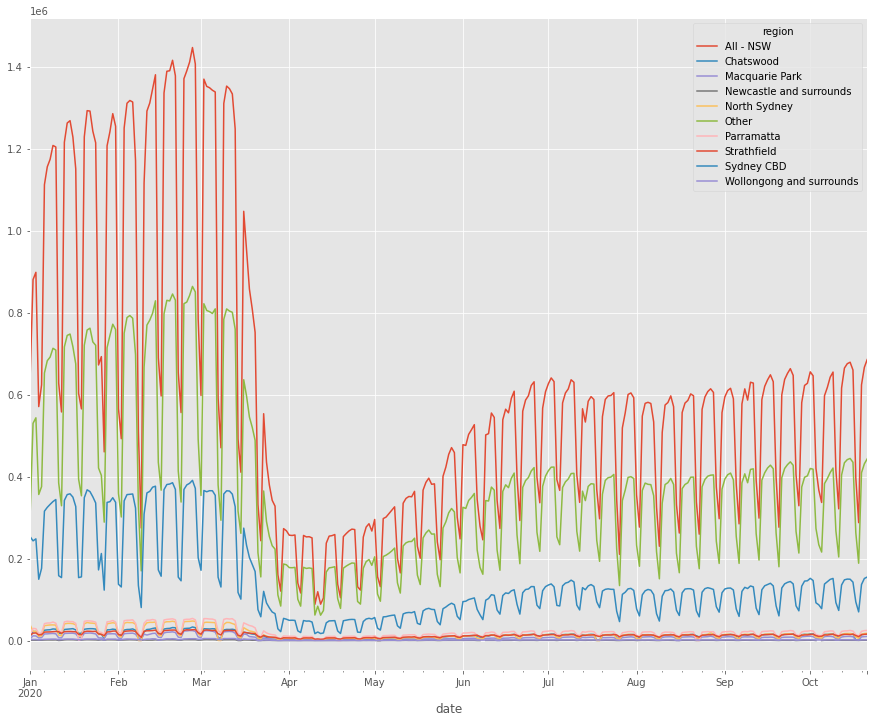

In [14]:
train_grouped['tap_on'].unstack().plot()

Plot the average of the previous days instead of the day to help eliminate noise.

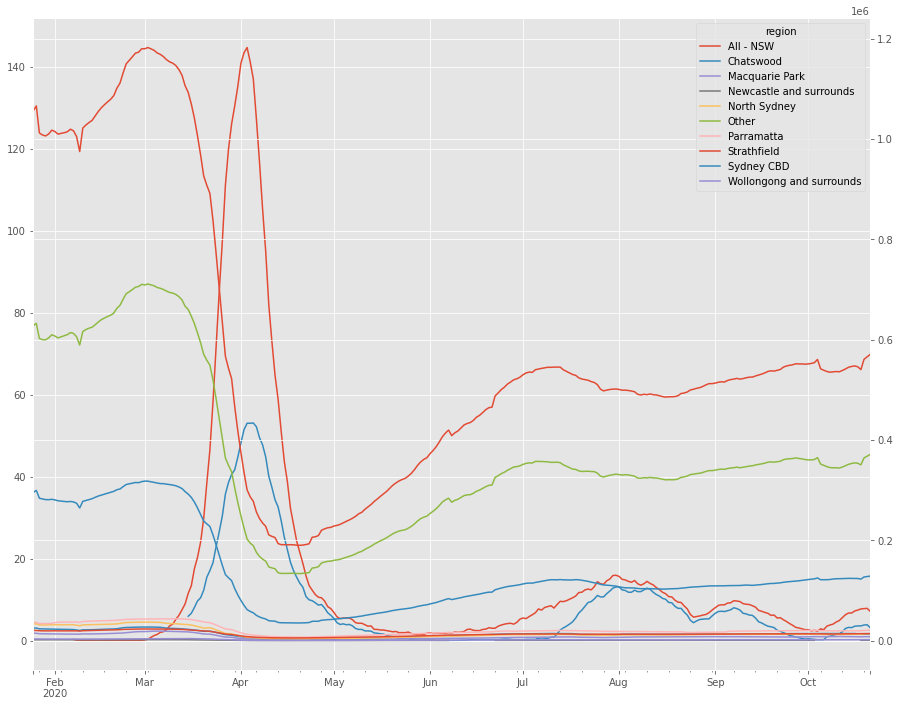

In [15]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

train_grouped['tap_on'].unstack().rolling(window=14).mean().plot(ax=ax2)
total_cases.rolling(window=14).mean().plot(ax=ax1)
local_cases.rolling(window=14).mean().plot(ax=ax1)

In [16]:
local_covid_df.head()

,date,postcode,source,health_district_name,local_gov_name
6,2020-03-02,2073.0,Locally acquired - source not identified,Northern Sydney,Ku-ring-gai (A)
8,2020-03-02,2077.0,Locally acquired - contact of a confirmed case...,Northern Sydney,Hornsby (A)
13,2020-03-03,2122.0,Locally acquired - contact of a confirmed case...,Northern Sydney,Ryde (C)
15,2020-03-04,2113.0,Locally acquired - contact of a confirmed case...,Northern Sydney,Ryde (C)
16,2020-03-04,2042.0,Locally acquired - contact of a confirmed case...,Sydney,Sydney (C)


In [17]:
local_covid_df['health_district_name'].unique()

array(['Northern Sydney', 'Sydney', 'Western Sydney', nan,
       'South Western Sydney', 'South Eastern Sydney',
       'Nepean Blue Mountains', 'Central Coast', 'Hunter New England',
       'Mid North Coast', 'Western NSW', 'Northern NSW',
       'Illawarra Shoalhaven', 'Southern NSW', 'Murrumbidgee', 'Far West',
       'Network with Vic'], dtype=object)

In [18]:
local_covid_df = local_covid_df.dropna()

Create the dataframe for the regression models.

In [19]:
reg_df = pd.DataFrame()

In [20]:
rolling_avg_train = train_grouped['tap_on'].unstack().rolling(window=14).mean()[13:]
reg_df['train_14_day_avg'] = rolling_avg_train['All - NSW']
reg_df.head()

,train_14_day_avg
date,
2020-01-14,9.383857e+05
2020-01-15,9.827000e+05
2020-01-16,1.007521e+06
2020-01-17,1.025536e+06
2020-01-18,1.027843e+06


In [21]:
rolling_avg_local_case = local_cases.rolling(window=14).mean()[13:]
rolling_avg_local_case.head()

2020-03-15     5.928571
2020-03-16     6.642857
2020-03-17     8.071429
2020-03-18     9.642857
2020-03-19    10.428571
Freq: D, dtype: float64

In [22]:
reg_df['local_cases_14_day_avg'] = rolling_avg_local_case

In [23]:
reg_df.head()

,train_14_day_avg,local_cases_14_day_avg
date,,
2020-01-14,9.383857e+05,NaN
2020-01-15,9.827000e+05,NaN
2020-01-16,1.007521e+06,NaN
2020-01-17,1.025536e+06,NaN
2020-01-18,1.027843e+06,NaN


In [24]:
reg_df.fillna(0,inplace=True)
reg_df.head()

,train_14_day_avg,local_cases_14_day_avg
date,,
2020-01-14,9.383857e+05,0.0
2020-01-15,9.827000e+05,0.0
2020-01-16,1.007521e+06,0.0
2020-01-17,1.025536e+06,0.0
2020-01-18,1.027843e+06,0.0


In [25]:
change_in_avg = reg_df.diff(periods=14)

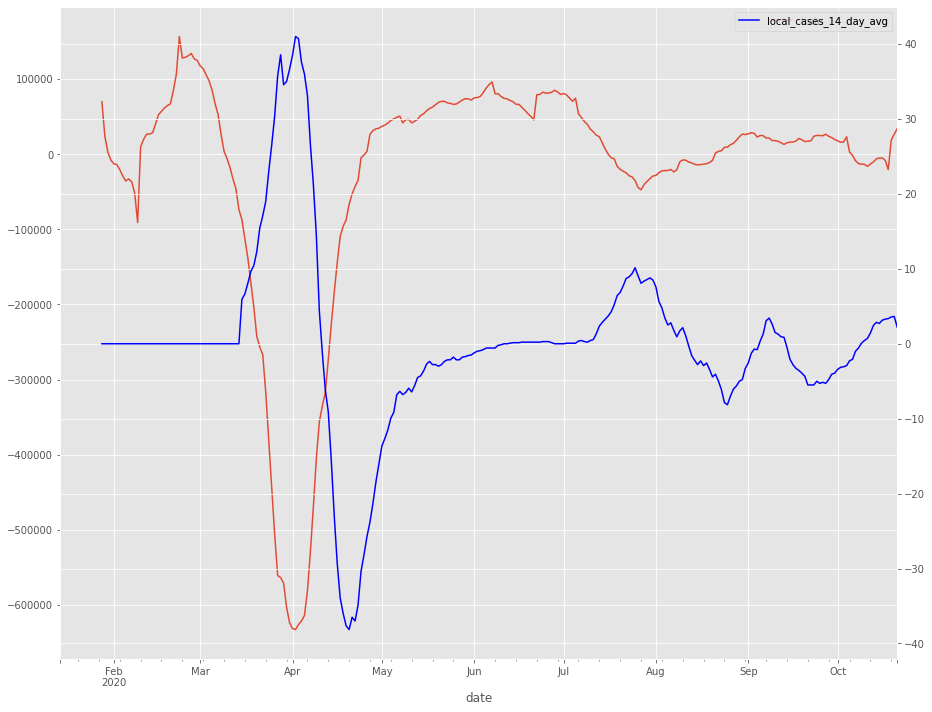

In [26]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
change_in_avg.plot(y='train_14_day_avg', ax=ax1)
change_in_avg.plot(y='local_cases_14_day_avg', ax=ax2, color='blue')


In [27]:
change_in_avg.columns = ['diff_14_days_train_avg', 'diff_14_days_local_cases_avg']
reg_df = reg_df.join(change_in_avg)

reg_df.head()

,train_14_day_avg,local_cases_14_day_avg,diff_14_days_train_avg,diff_14_days_local_cases_avg
date,,,,
2020-01-14,9.383857e+05,0.0,NaN,NaN
2020-01-15,9.827000e+05,0.0,NaN,NaN
2020-01-16,1.007521e+06,0.0,NaN,NaN
2020-01-17,1.025536e+06,0.0,NaN,NaN
2020-01-18,1.027843e+06,0.0,NaN,NaN


In [28]:
differences = [5, 7, 14, 21, 28]
for i in differences:
    change_in_case_avg = reg_df[['local_cases_14_day_avg']].diff(i)
    reg_df['diff_{}_days_local_cases_avg'.format(i)] = change_in_case_avg['local_cases_14_day_avg']

In [29]:
reg_df.head()

,train_14_day_avg,local_cases_14_day_avg,diff_14_days_train_avg,diff_14_days_local_cases_avg,diff_5_days_local_cases_avg,diff_7_days_local_cases_avg,diff_21_days_local_cases_avg,diff_28_days_local_cases_avg
date,,,,,,,,
2020-01-14,9.383857e+05,0.0,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-15,9.827000e+05,0.0,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-16,1.007521e+06,0.0,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-17,1.025536e+06,0.0,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-18,1.027843e+06,0.0,NaN,NaN,NaN,NaN,NaN,NaN


In [30]:
reg_df['train_next_14_day_avg'] = reg_df['train_14_day_avg'].shift(-1)
reg_df['local_cases_next_14_day_avg'] = reg_df['local_cases_14_day_avg'].shift(-1)
reg_df = reg_df[:-1]
reg_df.fillna(0, inplace=True)

In [31]:
reg_df

,train_14_day_avg,local_cases_14_day_avg,diff_14_days_train_avg,diff_14_days_local_cases_avg,diff_5_days_local_cases_avg,diff_7_days_local_cases_avg,diff_21_days_local_cases_avg,diff_28_days_local_cases_avg,train_next_14_day_avg,local_cases_next_14_day_avg
date,,,,,,,,,,
2020-01-14,9.383857e+05,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,9.827000e+05,0.000000
2020-01-15,9.827000e+05,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.007521e+06,0.000000
2020-01-16,1.007521e+06,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.025536e+06,0.000000
2020-01-17,1.025536e+06,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.027843e+06,0.000000
2020-01-18,1.027843e+06,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.023650e+06,0.000000
...,...,...,...,...,...,...,...,...,...,...
2020-10-16,5.476500e+05,3.500000,-5021.428571,3.142857,1.928571,2.214286,2.285714,0.000000,5.460071e+05,3.571429
2020-10-17,5.460071e+05,3.571429,-8192.857143,3.285714,1.428571,2.071429,2.500000,0.214286,5.403286e+05,3.571429
2020-10-18,5.403286e+05,3.571429,-20350.000000,3.357143,0.642857,2.000000,2.714286,0.428571,5.608214e+05,3.785714


In [32]:
import math
reg_df_train = reg_df.iloc[:math.floor(reg_df.shape[0] * 0.8)]
reg_df_test = reg_df.iloc[math.floor(reg_df.shape[0] * 0.8):]

In [33]:
reg_df_train.head()

,train_14_day_avg,local_cases_14_day_avg,diff_14_days_train_avg,diff_14_days_local_cases_avg,diff_5_days_local_cases_avg,diff_7_days_local_cases_avg,diff_21_days_local_cases_avg,diff_28_days_local_cases_avg,train_next_14_day_avg,local_cases_next_14_day_avg
date,,,,,,,,,,
2020-01-14,9.383857e+05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.827000e+05,0.0
2020-01-15,9.827000e+05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.007521e+06,0.0
2020-01-16,1.007521e+06,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.025536e+06,0.0
2020-01-17,1.025536e+06,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.027843e+06,0.0
2020-01-18,1.027843e+06,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.023650e+06,0.0


In [34]:
reg_df_test.head()

,train_14_day_avg,local_cases_14_day_avg,diff_14_days_train_avg,diff_14_days_local_cases_avg,diff_5_days_local_cases_avg,diff_7_days_local_cases_avg,diff_21_days_local_cases_avg,diff_28_days_local_cases_avg,train_next_14_day_avg,local_cases_next_14_day_avg
date,,,,,,,,,,
2020-08-25,501164.285714,4.357143,9421.428571,-8.142857,-3.500000,-4.857143,-7.428571,-7.071429,503071.428571,4.785714
2020-08-26,503071.428571,4.785714,12728.571429,-7.000000,-3.071429,-3.571429,-7.000000,-7.285714,504307.142857,5.142857
2020-08-27,504307.142857,5.142857,14478.571429,-6.071429,-1.785714,-2.714286,-7.142857,-7.642857,506792.857143,5.214286
2020-08-28,506792.857143,5.214286,18528.571429,-5.642857,-1.000000,-2.642857,-6.714286,-7.857143,509857.142857,5.285714
2020-08-29,509857.142857,5.285714,23292.857143,-5.000000,0.357143,-1.642857,-6.642857,-7.785714,512357.142857,5.285714


In [35]:
from sklearn.linear_model import LinearRegression
train_model = LinearRegression()
reg_df_train_X = reg_df_train.drop(['train_next_14_day_avg', 'local_cases_next_14_day_avg'], axis=1)
reg_df_train_y = reg_df_train['train_next_14_day_avg']
reg_df_test_X = reg_df_test.drop(['train_next_14_day_avg', 'local_cases_next_14_day_avg'], axis=1)
reg_df_test_y = reg_df_test['train_next_14_day_avg']
train_model.fit(reg_df_train_X, reg_df_train_y)

LinearRegression()

In [36]:
train_model.coef_

array([ 9.95703867e-01,  1.42117147e+02,  7.22704231e-02,  7.84503983e+02,
       -2.28659004e+03,  4.88348866e+02, -4.33330013e+02,  1.63870641e+02])

In [37]:
predicted = train_model.predict(reg_df_test.drop(['train_next_14_day_avg', 'local_cases_next_14_day_avg'], axis=1))

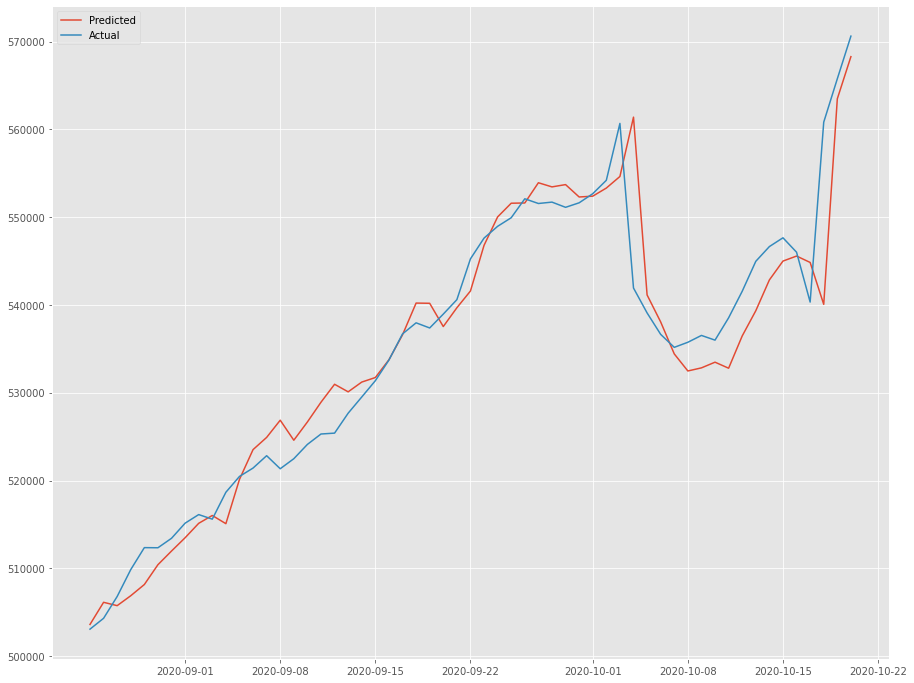

In [38]:
plt.plot(reg_df_test.index, predicted)
plt.plot(reg_df_test['train_next_14_day_avg'])
plt.legend(['Predicted', 'Actual'])

In [39]:
r2_score(reg_df_test['train_next_14_day_avg'], predicted)

0.9153608432572465

In [40]:
covid_model = LinearRegression()
covid_model.fit(reg_df_train_X, reg_df_train['local_cases_next_14_day_avg'])

LinearRegression()

In [41]:
covid_predict = covid_model.predict(reg_df_test.drop(['train_next_14_day_avg', 'local_cases_next_14_day_avg'], axis=1))

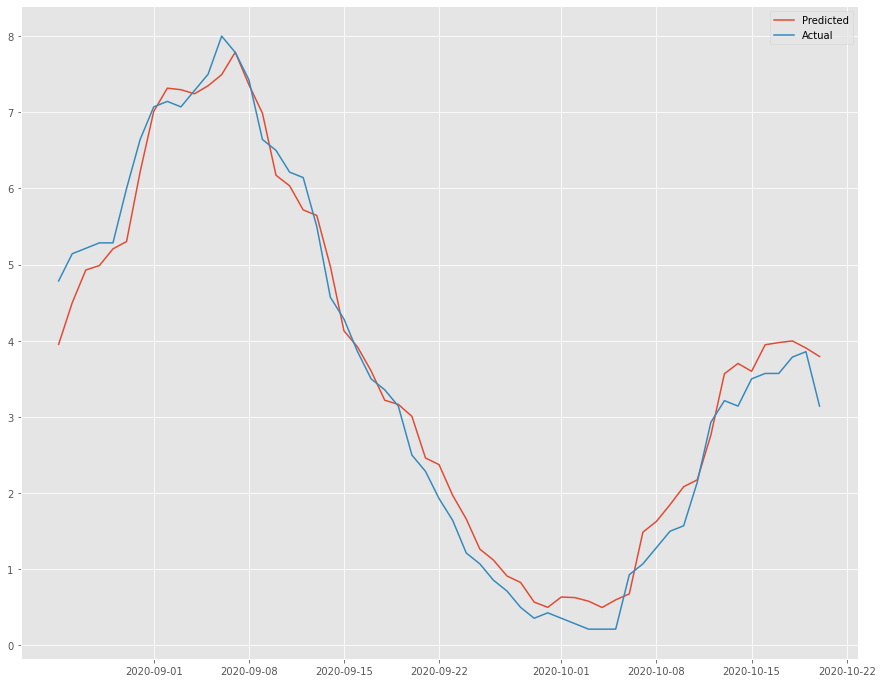

In [42]:
plt.plot(reg_df_test.index, covid_predict)
plt.plot(reg_df_test['local_cases_next_14_day_avg'])
plt.legend(['Predicted', 'Actual'])

In [43]:
r2_score(reg_df_test['local_cases_next_14_day_avg'], covid_predict)

0.980125520564733

Attempt to predict the future.

In [44]:
future_df = reg_df[-29:]
start_date = future_df.index[0]
future_df = future_df.reset_index(drop=True)

In [45]:
for i in range(28, 300):
    predictors = future_df[i:i+1].drop(['train_next_14_day_avg', 'local_cases_next_14_day_avg'], axis=1)
    next_train = train_model.predict(predictors)
    next_local_cases = covid_model.predict(predictors)
    future_df = future_df.append({'train_14_day_avg': next_train[0],
                                  'local_cases_14_day_avg': next_local_cases[0],
                                  'diff_14_days_train_avg': next_train[0] - future_df['train_14_day_avg'].iloc[-14],
                                  'diff_14_days_local_cases_avg': next_local_cases[0] - future_df['local_cases_14_day_avg'].iloc[-14],
                                  'diff_5_days_local_cases_avg': next_local_cases[0] - future_df['local_cases_14_day_avg'].iloc[-5],
                                  'diff_7_days_local_cases_avg': next_local_cases[0] - future_df['local_cases_14_day_avg'].iloc[-7],
                                  'diff_21_days_local_cases_avg': next_local_cases[0] - future_df['local_cases_14_day_avg'].iloc[-21],
                                  'diff_28_days_local_cases_avg': next_local_cases[0] - future_df['local_cases_14_day_avg'].iloc[-28],
                                 },
                                 ignore_index=True)

In [46]:
future_df.index = pd.date_range(start_date, periods=301)

In [47]:
future_df

,train_14_day_avg,local_cases_14_day_avg,diff_14_days_train_avg,diff_14_days_local_cases_avg,diff_5_days_local_cases_avg,diff_7_days_local_cases_avg,diff_21_days_local_cases_avg,diff_28_days_local_cases_avg,train_next_14_day_avg,local_cases_next_14_day_avg
2020-09-22,540600.000000,2.285714,17771.428571,-5.500000,-1.571429,-2.285714,-4.357143,-2.071429,545250.000000,1.928571
2020-09-23,545250.000000,1.928571,23907.142857,-5.500000,-1.571429,-2.357143,-5.142857,-2.857143,547614.285714,1.642857
2020-09-24,547614.285714,1.642857,25128.571429,-5.000000,-1.714286,-2.214286,-5.500000,-3.500000,548957.142857,1.214286
2020-09-25,548957.142857,1.214286,24842.857143,-5.285714,-1.928571,-2.285714,-5.857143,-4.000000,549935.714286,1.071429
2020-09-26,549935.714286,1.071429,24635.714286,-5.142857,-1.428571,-2.285714,-6.214286,-4.214286,552092.857143,0.857143
...,...,...,...,...,...,...,...,...,...,...
2021-07-15,640246.302821,5.210928,1508.571174,0.028130,0.011158,0.015327,0.037314,0.041831,NaN,NaN
2021-07-16,640332.182081,5.213260,1468.064611,0.028830,0.011336,0.015599,0.038597,0.043842,NaN,NaN
2021-07-17,640415.143797,5.215619,1427.423593,0.029486,0.011500,0.015850,0.039814,0.045767,NaN,NaN
2021-07-18,640495.198783,5.218002,1386.688640,0.030097,0.011648,0.016078,0.040965,0.047606,NaN,NaN


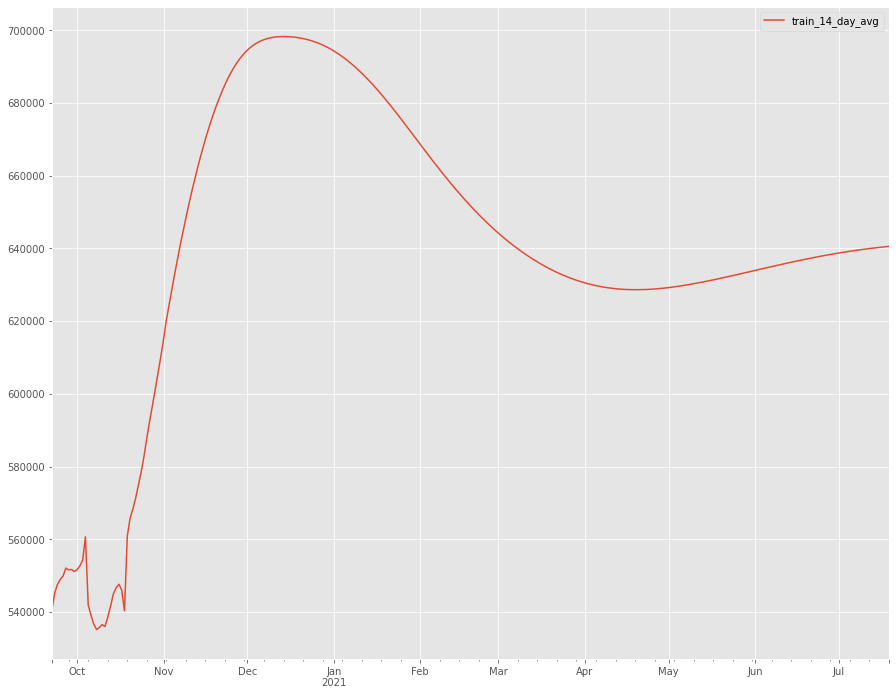

In [48]:
future_df.plot(y='train_14_day_avg')

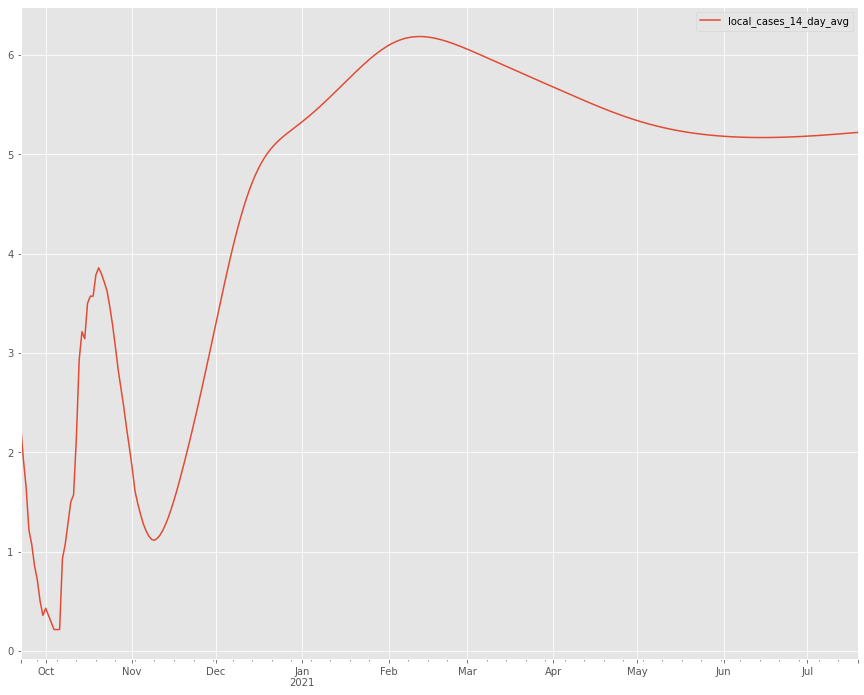

In [49]:
future_df.plot(y='local_cases_14_day_avg')